# A first hello world to Blackjax

This is a first example, showing how to use Blackjax. 

Much of the code is adapted from https://blackjax-devs.github.io/blackjax/examples/quickstart.html

In [57]:
import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
import numpy as np
import blackjax

### Linear Regression

A simple Data Set

In [58]:
import jax.random as jrandom
key = jrandom.PRNGKey(0)
if False:
    import jax.numpy as jnp

    N = 5
    x = jnp.linspace(-2, 2, num=N)
    means = 2 * x + 1  # Calculate means based on your linear model
    y = means + jrandom.normal(key, shape=(N,))  # Generate standard normal data and shift by the means
    x,y
else:
    #!pip install edudat
    import edudat
    from edudat import load_data
    df = load_data('sbp.csv', verbose=True)
    x = df['x'].values
    y = df['y'].values
    N = len(x)
    display(df.head())

Using cached sbp.csv


,x,y
0,22,131
1,41,139
2,52,128
3,23,128
4,41,171


#### Log Density, defineing the model

We define a function that calculates the log density of the model. We use a natural parameterization of the model.

In [59]:
from jax.scipy.stats import norm, uniform

def logdensity_fn(a,b,sigma): 
    # Prior distributions for a, b, and sigma
    log_prior_a = norm.logpdf(a, 0, 10) # uniform prior on a between -100,100
    log_prior_b = norm.logpdf(b, 0, 10)
    log_prior_sigma = uniform.logpdf(sigma, 0.1, 100)
        
    # The likelihood of the data given the model
    log_likelihood = jnp.sum(norm.logpdf(y, a * x + b, sigma))
    
    # Sum of log prior probabilities and the log likelihood
    log_posterior = log_prior_a + log_prior_b + log_prior_sigma + log_likelihood
    return log_posterior

logdensity_fn(0,0,1.) # R Code -328281.9

Array(-328281.94, dtype=float32)

#### Creating an adapter for a model `log_density(x)`

It is convenient to the log_density function to have for all models the signature `log_density(x)`, where x is a dictionary of parameters. This makes it easier to use, since the syntax is the same for differnt models.

In python we can use the `lambda` function to create an adapter and use the **x syntax to unpack the dictionary into keyword arguments.

```python
logdensity = lambda x: logdensity_fn(**x)
```

Unrolls the dictionary into keyword arguments.

In [60]:
logdensity = lambda x: logdensity_fn(**x)
initial_position = {'a': 0., 'b': 0., 'sigma': 1.}
#initial_position = {'a': 0., 'b': 0.} #logdensity_fn() missing 1 required positional argument: 'sigma' 
#initial_position = {'a': 0., 'b': 0., 'sigma': 1., 'gamma': 0.1} #not working got an unexpected keyword argument 'gamma'
logdensity(initial_position)

Array(-328281.94, dtype=float32)

## Simple HMC Sampling

### Defining the sampler

Let's define a HMC sampler. We set the paramters of the sampler fixed.

In [61]:
# HMC Sampler setup
step_size = 1e-3
num_integration_steps = 30 # Number of Leapfrog steps for the Hamiltonian Dynamics
inverse_mass_matrix = np.ones(3)

# Define the HMC transition kernel
hmc = blackjax.hmc(logdensity, step_size, inverse_mass_matrix, num_integration_steps)

When we start sampling more then just the initial position is required, also gradients need to be provied. 

In [62]:
# Initialize the sampler's state
initial_state = hmc.init(initial_position)
initial_state

HMCState(position={'a': 0.0, 'b': 0.0, 'sigma': 1.0}, logdensity=Array(-328281.94, dtype=float32), logdensity_grad={'a': Array(220684., dtype=float32, weak_type=True), 'b': Array(4575., dtype=float32, weak_type=True), 'sigma': Array(656448., dtype=float32, weak_type=True)})

### Defining the inference loop

In [63]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

### HMC Kernel

In [64]:
%%time
hmc_kernel = jax.jit(hmc.step)
rng_key, sample_key = jax.random.split(key)
hmc_samples = inference_loop(sample_key, hmc_kernel, initial_state, 10000)
type(hmc_samples), type(hmc_samples.position), hmc_samples.position

CPU times: user 276 ms, sys: 8.8 ms, total: 285 ms
Wall time: 276 ms


(blackjax.mcmc.hmc.HMCState,
 dict,
 {'a': Array([9.483974 , 8.984148 , 8.472546 , ..., 2.783123 , 2.7958553,
         2.758244 ], dtype=float32, weak_type=True),
  'b': Array([0.18881379, 0.16702752, 0.14148107, ..., 1.9141825 , 1.916669  ,
         1.9016392 ], dtype=float32, weak_type=True),
  'sigma': Array([21.515581, 21.660173, 21.79324 , ..., 27.045313, 27.098364,
         27.107788], dtype=float32, weak_type=True)})

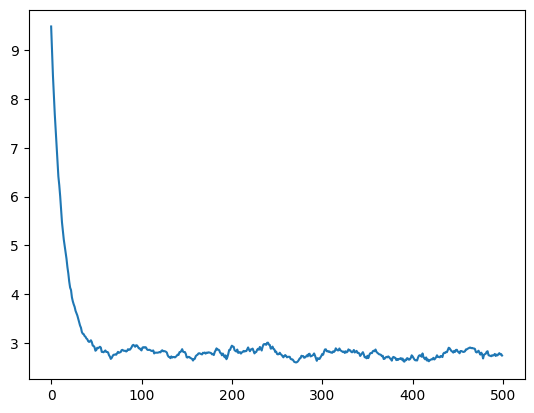

In [65]:
from matplotlib import pyplot as plt
plt.plot(hmc_samples.position['a'][0:500])

### Nuts
NUTS is a dynamic algorithm: the number of integration steps is determined at runtime. We still need to specify a step size and a mass matrix:

In [66]:
inverse_mass_matrix = np.ones(3)
step_size = 1e-3
nuts = blackjax.nuts(logdensity, step_size, inverse_mass_matrix)
initial_state = nuts.init(initial_position)
initial_state

HMCState(position={'a': 0.0, 'b': 0.0, 'sigma': 1.0}, logdensity=Array(-328281.94, dtype=float32), logdensity_grad={'a': Array(220684., dtype=float32, weak_type=True), 'b': Array(4575., dtype=float32, weak_type=True), 'sigma': Array(656448., dtype=float32, weak_type=True)})

In [67]:
%%time
rng_key, sample_key = jax.random.split(rng_key)
nuts_samples = inference_loop(sample_key, nuts.step, initial_state, 4_000)

CPU times: user 2.08 s, sys: 22.5 ms, total: 2.11 s
Wall time: 1.7 s


### Finding the sampling parameters using Stan

Specifying the step size and inverse mass matrix is cumbersome. We can use Stan’s adaptation to get reasonable values for them so we have, in practice, no parameter to specify.

In [68]:
%%time
warmup = blackjax.window_adaptation(blackjax.nuts, logdensity)
rng_key, warmup_key, sample_key = jax.random.split(rng_key, 3)
(state, parameters), _ = warmup.run(warmup_key, initial_position, num_steps=10000)
parameters

CPU times: user 965 ms, sys: 18.6 ms, total: 983 ms
Wall time: 982 ms


{'step_size': Array(0.34177116, dtype=float32, weak_type=True),
 'inverse_mass_matrix': Array([4.6370767e-02, 9.8208611e+01, 2.1380449e+01], dtype=float32)}

In [107]:
### NUTS with gradient counting
from functools import wraps
# Create a wrapper to count gradient evaluations
def gradient_counting_logdensity(x):
    global gradient_eval_count
    gradient_eval_count += 1
    return logdensity(x)

# Create a wrapper to count gradient evaluations
def gradient_counting_logdensity(x):
    global gradient_eval_count
    gradient_eval_count += 1
    return logdensity(x)

# Create the NUTS kernel
def create_nuts_kernel(logdensity, **parameters):
    kernel = blackjax.nuts(logdensity, **parameters).step
    
    @wraps(kernel)
    def wrapped_kernel(rng_key, state):
        global gradient_eval_count
        gradient_eval_count = 0  # Reset the counter before each run
        new_state, info = kernel(rng_key, state)
        return new_state, info
    
    return wrapped_kernel

# Define the inference loop
def inference_loop(rng_key, kernel, state, num_samples):
    samples = []
    infos = []
    gradient_counts = []
    for _ in range(num_samples):
        state, info = kernel(rng_key, state)
        samples.append(state.position)
        infos.append(info)
        gradient_counts.append(gradient_eval_count)  # Append current gradient count
        rng_key, _ = jax.random.split(rng_key)
    return samples, infos, gradient_counts


kernel = create_nuts_kernel(gradient_counting_logdensity, **parameters)

In [110]:
%%time
stan_samples = inference_loop(sample_key, kernel, state, 10)
stan_samples

CPU times: user 5.46 s, sys: 222 ms, total: 5.68 s
Wall time: 5.68 s


([{'a': Array(2.6031015, dtype=float32, weak_type=True),
   'b': Array(14.700907, dtype=float32, weak_type=True),
   'sigma': Array(33.14059, dtype=float32, weak_type=True)},
  {'a': Array(2.7361262, dtype=float32, weak_type=True),
   'b': Array(11.204056, dtype=float32, weak_type=True),
   'sigma': Array(30.788488, dtype=float32, weak_type=True)},
  {'a': Array(2.6893682, dtype=float32, weak_type=True),
   'b': Array(10.553462, dtype=float32, weak_type=True),
   'sigma': Array(34.701725, dtype=float32, weak_type=True)},
  {'a': Array(1.9894518, dtype=float32, weak_type=True),
   'b': Array(42.571438, dtype=float32, weak_type=True),
   'sigma': Array(23.799406, dtype=float32, weak_type=True)},
  {'a': Array(1.8236237, dtype=float32, weak_type=True),
   'b': Array(44.3161, dtype=float32, weak_type=True),
   'sigma': Array(22.087214, dtype=float32, weak_type=True)},
  {'a': Array(1.8280561, dtype=float32, weak_type=True),
   'b': Array(47.661285, dtype=float32, weak_type=True),
   'sigma

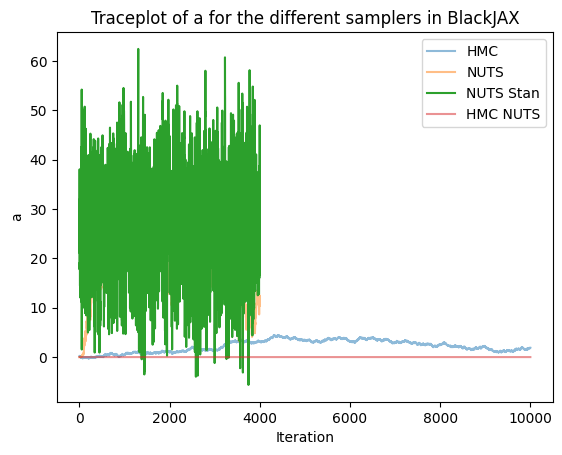

In [97]:
from matplotlib import pyplot as plt
plt.plot(hmc_samples.position['b'], alpha=0.5, label='HMC')
plt.plot(nuts_samples.position['b'], label='NUTS',alpha=0.5)
plt.plot(stan_samples.position['b'], label='NUTS Stan')
plt.xlabel('Iteration')
plt.ylabel('a')
plt.title('Traceplot of a for the different samplers in BlackJAX')
plt.legend()

In [73]:
hmc_vals = jnp.array([hmc_samples.position[a] for a in hmc_samples.position.keys()])
nuts_vals = jnp.array([nuts_samples.position[a] for a in nuts_samples.position.keys()])
stan_vals = jnp.array([stan_samples.position[a] for a in stan_samples.position.keys()])
hmc_vals.mean(axis=1)

Array([ 2.756658 ,  2.2152593, 24.947882 ], dtype=float32)

In [74]:
# Make table
import pandas as pd
df = pd.DataFrame(
    {'HMC': hmc_vals[:,1000:].mean(axis=1), 
     'NUTS': nuts_vals[:,1000:].mean(axis=1), 
     'NUTS Stan': stan_vals[:,1000:].mean(axis=1),
     'R Code Stan': (2.26, 27.42, 29.08)})
df

,HMC,NUTS,NUTS Stan,R Code Stan
0,2.741894,2.417717,2.282495,2.26
1,2.439280,19.550291,26.688869,27.42
2,25.229450,32.185707,29.193155,29.08


#### Using ArviZ 

In [75]:
import arviz as az

#Adapter from https://blackjax-devs.github.io/sampling-book/models/change_of_variable_hmc.html
def arviz_trace_from_states(states, burn_in=0):
    position = states.position
    if isinstance(position, jax.Array):  # if states.position is array of samples
        position = dict(samples=position)
    else:
        try:
            position = position._asdict()
        except AttributeError:
            pass

    samples = {}
    for param in position.keys():
        ndims = len(position[param].shape)
        if ndims >= 2:
            samples[param] = jnp.swapaxes(position[param], 0, 1)[
                :, burn_in:
            ]  # swap n_samples and n_chains

        if ndims == 1:
            samples[param] = position[param]

    trace_posterior = az.convert_to_inference_data(samples)
    trace = az.concat(trace_posterior)
    return trace

,HMC,NUTS,NUTS Stan
a,182.79,4.69,1025.00
b,5.04,4.05,927.40
sigma,1.83,15.68,1020.65


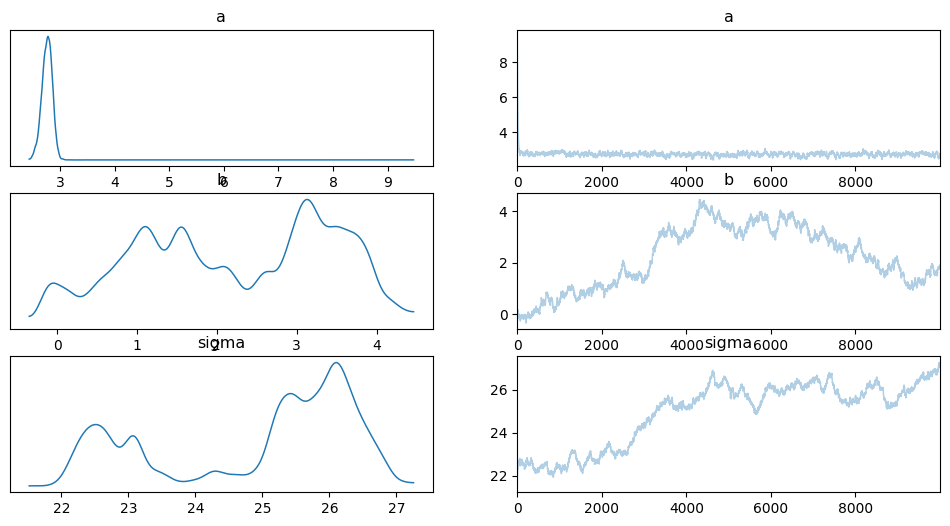

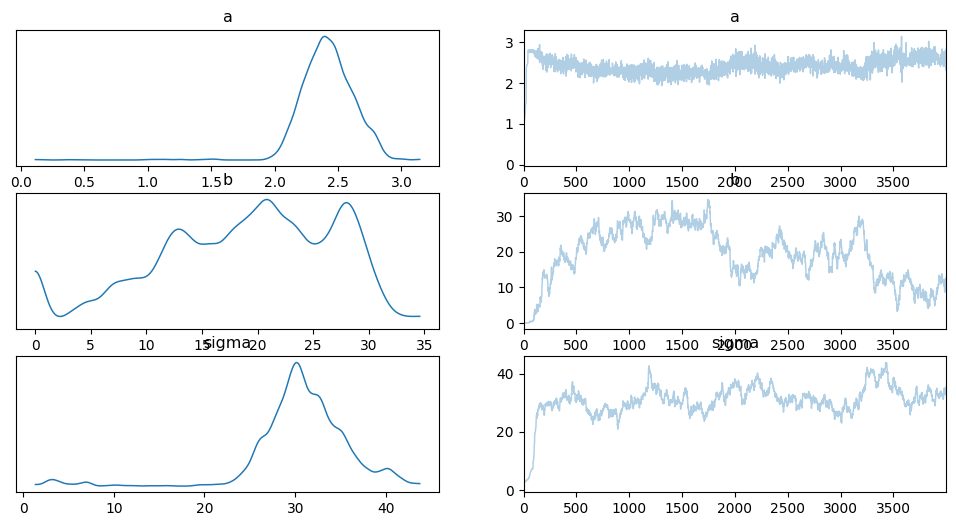

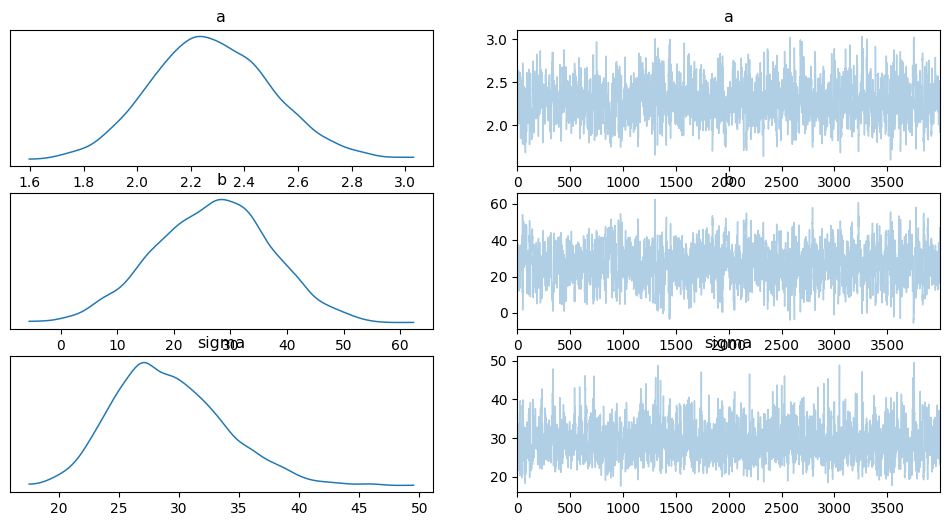

In [76]:
hmc_trace = arviz_trace_from_states(hmc_samples, burn_in=1000)
arcviz.plot_trace(hmc_trace, compact=True)
#hmc_ess = arcviz.ess(hmc_trace)
df_ess =  pd.DataFrame(arcviz.ess(hmc_trace).to_pandas().T)

nuts_trace = arviz_trace_from_states(nuts_samples, burn_in=1000)
arcviz.plot_trace(nuts_trace, compact=True)
df_ess = pd.concat([df_ess, arcviz.ess(nuts_trace).to_pandas().T], axis=1)

stan_trace = arviz_trace_from_states(stan_samples, burn_in=1000)
arcviz.plot_trace(stan_trace, compact=True)
stan_ess = arcviz.ess(stan_trace)
df_ess = pd.concat([df_ess, arcviz.ess(stan_trace).to_pandas().T], axis=1)

df_ess.columns = ['HMC', 'NUTS', 'NUTS Stan']
df_ess.round(2)